In [152]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns
import robust_loss_pytorch.general
import numpy.random as npr
from robust_loss_pytorch import distribution
import random
import torch.nn as nn
# Construct some regression data with some extreme outliers.
np.random.seed(1234)

class RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)
    def forward(self, x): 
        return self.linear(x[:,None])[:,0]
    
class Poly2RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(2, 1)
    def forward(self, x): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        return self.linear(x)[:,0]
    
class Poly2RegressionModel_with_class(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel_with_class, self).__init__() 
        self.linear = torch.nn.Linear(3, 1)
    def forward(self, x, c): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        x = torch.cat([x, c.view(-1,1)], axis=1)
        return self.linear(x)[:,0]

def plot_regression(regression, u=None, c=None):
    # A helper function for plotting a regression module.
    x_plot = np.linspace(min(x), max(x), 500)
    if c is None:
        y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
    else:
        y_plot = regression(torch.Tensor(x_plot), c).detach().numpy()
#     y_plot_true = x_plot * scale_true + shift_true
    
    plt.figure(0, figsize=(4,4))
    if u is not None:
        sns.scatterplot(x, y, hue=U)
    else:
        sns.scatterplot(x, y)
#     plt.plot(x_plot, y_plot_true, color='k')
    plt.plot(x_plot, y_plot, color='navy', label='regressor')
    plt.legend()

In [24]:
def generate_delta_noise(n:int, x_range:list, delta=10, rate=0.01, beta1=3, beta0=0, scale=1, hetero=False):
    X = npr.uniform(x_range[0], x_range[1], n)
    X = np.array(sorted(X))
    scales = scale*np.ones(len(X))
    if hetero:
        scales[X>0]+=(X**2+5*X)[X>0]
    Y = npr.normal(beta1*X+beta0, scales)
    
    
    noise = np.array([False]*n)
    idx = np.random.choice(int(n/5), int(n*rate), replace=False)
    noise[idx]= True
    Y[noise] = npr.normal(beta1*(X[noise]+delta)+beta0)
    return X, Y, noise

# Heteroskedastic data

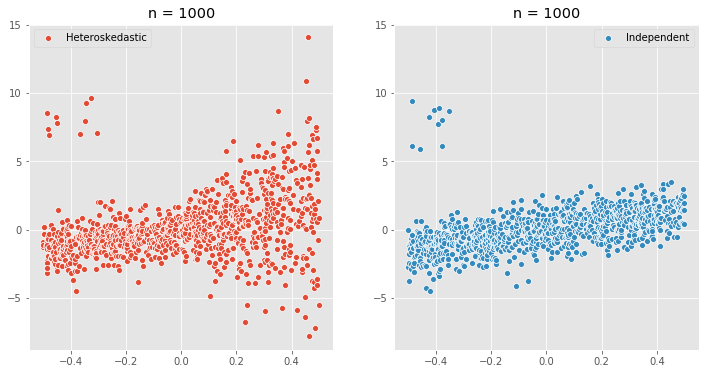

In [197]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

x_indep, y_indep, noise_indep = generate_delta_noise(1000, [-0.5, 0.5], delta=3, rate=0.01, hetero=False, beta0=0)
x_hetero, y_hetero, noise_hetero = generate_delta_noise(1000, [-0.5, 0.5], delta=3, rate=0.01, hetero=True, beta0=0)
ax[0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_hetero, y_hetero, label='Heteroskedastic', color=palette[0], ax=ax[0])
ax[1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_indep, y_indep, label='Independent', color=palette[1], ax=ax[1])
ax[0].set_title('n = 1000')
ax[1].set_title('n = 1000')
plt.savefig('synthetic_data_noise.png')

# Density data

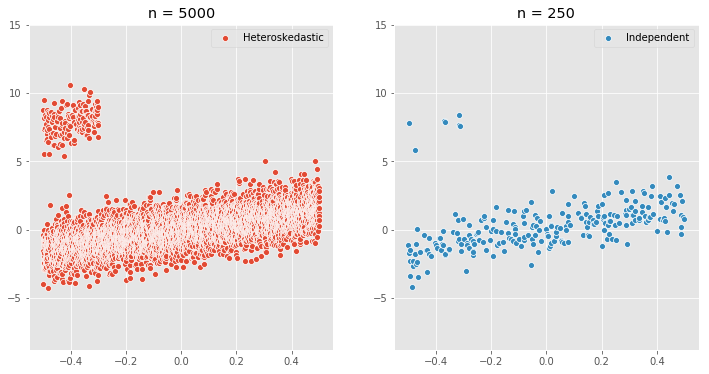

In [239]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

x_dense, y_dense, noise_dense = generate_delta_noise(5000, [-0.5, 0.5], delta=3, rate=0.03, hetero=False, beta0=0)
x_sparse, y_sparse, noise_sparse = generate_delta_noise(250, [-0.5, 0.5], delta=3, rate=0.03, hetero=False, beta0=0)
ax[0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_dense, y_dense, label='Heteroskedastic', color=palette[0], ax=ax[0])
ax[1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_sparse, y_sparse, label='Independent', color=palette[1], ax=ax[1])
ax[0].set_title('n = 5000')
ax[1].set_title('n = 250')
plt.savefig('synthetic_data_sparse.png')

## Linear regression with regular MSE

0   : loss=279.950836
500 : loss=234.482025
1000: loss=234.219788
1500: loss=234.219803
MSE: 4.684396


OrderedDict([('weight', Parameter containing:
              tensor([[2.5947]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.1051], requires_grad=True))])

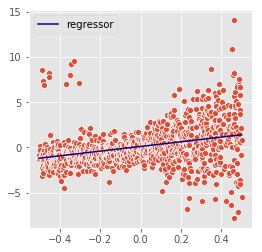

In [223]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(list(params), lr = 0.01) 
x = torch.Tensor(x_hetero)
y = torch.Tensor(y_hetero)
for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

0   : loss=155.023666
500 : loss=89.449081
1000: loss=89.448944
1500: loss=89.448944
MSE: 1.788979


OrderedDict([('weight', Parameter containing:
              tensor([[2.5247]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.0575], requires_grad=True))])

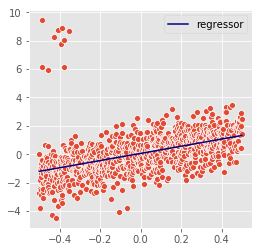

In [224]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_indep)
y = torch.Tensor(y_indep)
for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

## Linear regression with Adaptive Roust loss

0   : loss=3.538688  alpha=1.997990  scale=1.006333
500 : loss=2.165719  alpha=1.779561  scale=1.980148
1000: loss=2.056353  alpha=0.754874  scale=1.152893
1500: loss=2.034194  alpha=0.407192  scale=0.836472
2000: loss=2.034106  alpha=0.389522  scale=0.819231
MSE: 4.701606


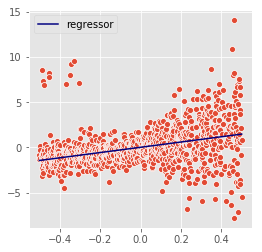

In [225]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_hetero)
y = torch.Tensor(y_hetero)
hetero_alpha = []
hetero_scale = []
for epoch in range(2500): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    hetero_alpha.append(adaptive.alpha()[0,0].data.numpy())
    hetero_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))

0   : loss=2.064330  alpha=1.997990  scale=1.006333
500 : loss=1.555150  alpha=0.993707  scale=0.767815
1000: loss=1.539219  alpha=0.662825  scale=0.613288
1500: loss=1.539219  alpha=0.662825  scale=0.613288
2000: loss=1.539219  alpha=0.662825  scale=0.613288


OrderedDict([('weight', Parameter containing:
              tensor([[2.8990]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.0147], requires_grad=True))])

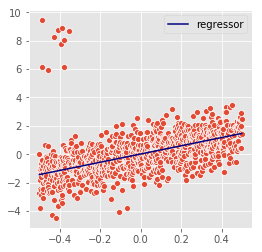

In [226]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_indep)
y = torch.Tensor(y_indep)
indep_alpha = []
indep_scale = []
for epoch in range(2500): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    indep_alpha.append(adaptive.alpha()[0,0].data.numpy())
    indep_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters

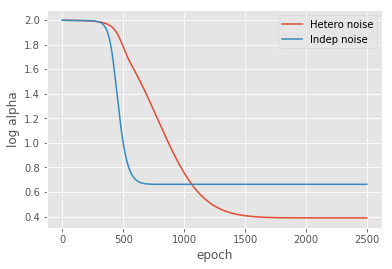

In [227]:
sns.lineplot(np.arange(len(hetero_alpha)), np.array(hetero_alpha), label="Hetero noise")
sns.lineplot(np.arange(len(hetero_alpha)), np.array(indep_alpha), label="Indep noise")
plt.xlabel('epoch')
plt.ylabel('log alpha')
plt.savefig('alpha_convergence_noise.png')

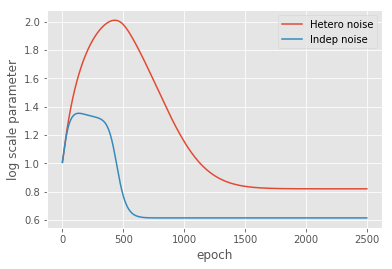

In [228]:
sns.lineplot(np.arange(len(hetero_alpha)), np.array(hetero_scale), label="Hetero noise")
sns.lineplot(np.arange(len(hetero_alpha)), np.array(indep_scale), label="Indep noise")
plt.xlabel('epoch')
plt.ylabel('log scale parameter')
plt.savefig('scale_convergence_noise.png')

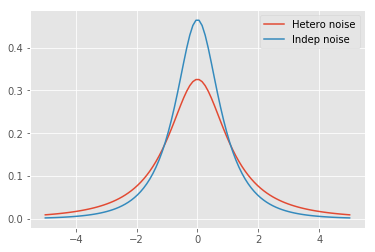

In [229]:
dist = distribution.Distribution()
alpha=hetero_alpha[-1]
scale=hetero_scale[-1]
x_range = 5
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Hetero noise')

alpha=indep_alpha[-1] 
scale=indep_scale[-1]
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Indep noise')
plt.savefig('learned_kernel_noise.png')

0   : loss=2.947396  alpha=1.997990  scale=1.006333
500 : loss=1.929158  alpha=1.536818  scale=1.556097
1000: loss=1.678899  alpha=0.342170  scale=0.574269
1500: loss=1.678835  alpha=0.332022  scale=0.565630
2000: loss=1.678835  alpha=0.332016  scale=0.565626
MSE: 3.438558


OrderedDict([('weight', Parameter containing:
              tensor([[2.8151]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.0212], requires_grad=True))])

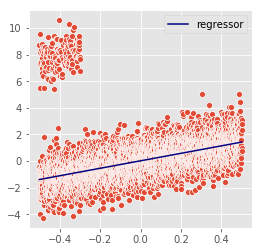

In [240]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_dense)
y = torch.Tensor(y_dense)
dense_alpha = []
dense_scale = []
for epoch in range(2500): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    dense_alpha.append(adaptive.alpha()[0,0].data.numpy())
    dense_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

0   : loss=3.046369  alpha=1.997990  scale=1.006333
500 : loss=1.908660  alpha=1.722903  scale=1.575835
1000: loss=1.617865  alpha=0.323250  scale=0.529253
1500: loss=1.617665  alpha=0.305114  scale=0.514608
2000: loss=1.617665  alpha=0.305108  scale=0.514603
MSE: 3.092144


OrderedDict([('weight', Parameter containing:
              tensor([[3.2880]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.0446], requires_grad=True))])

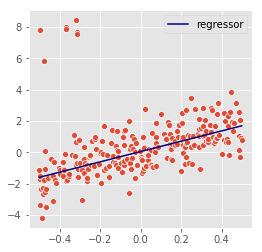

In [241]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_sparse)
y = torch.Tensor(y_sparse)
sparse_alpha = []
sparse_scale = []
for epoch in range(2500): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    sparse_alpha.append(adaptive.alpha()[0,0].data.numpy())
    sparse_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

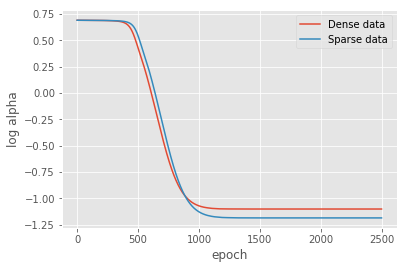

In [242]:
sns.lineplot(np.arange(len(dense_alpha)), np.log(np.array(dense_alpha)), label="Dense data")
sns.lineplot(np.arange(len(dense_alpha)), np.log(np.array(sparse_alpha)), label="Sparse data")
plt.xlabel('epoch')
plt.ylabel('log alpha')
plt.savefig('alpha_convergence_sparse.png')

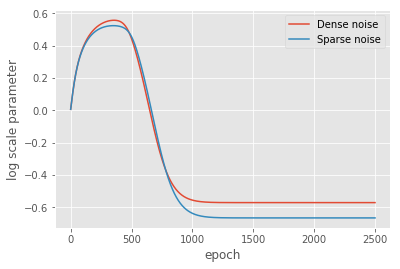

In [243]:
sns.lineplot(np.arange(len(dense_alpha)), np.log(np.array(dense_scale)), label="Dense noise")
sns.lineplot(np.arange(len(dense_alpha)), np.log(np.array(sparse_scale)), label="Sparse noise")
plt.xlabel('epoch')
plt.ylabel('log scale parameter')
plt.savefig('scale_convergence_sparse.png')

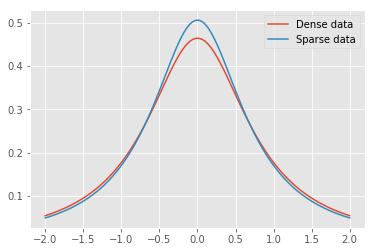

In [244]:
dist = distribution.Distribution()
alpha=dense_alpha[-1]
scale=dense_scale[-1]
x_range = 2
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Dense data')

alpha=sparse_alpha[-1] 
scale=sparse_scale[-1]
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='Sparse data')
plt.savefig('learned_kernel_sparse.png')

# Optimize Alpha for each data

0   : loss=0.361844
1000: loss=0.003663
2000: loss=0.001061
3000: loss=0.000464
4000: loss=0.000238
5000: loss=0.000131
6000: loss=0.000075
7000: loss=0.000044
8000: loss=0.000027
9000: loss=0.000016


OrderedDict([('weight', Parameter containing:
              tensor([[3.5158]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([0.3037], requires_grad=True))])

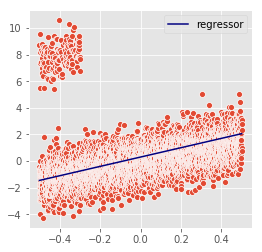

In [422]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
alpha_dense = nn.Parameter(torch.Tensor([1]*len(x_dense)))
scale_dense = nn.Parameter(torch.Tensor([1]*len(x_dense)))
optimizer = torch.optim.Adam([scale_dense, alpha_dense]+list(params), lr = 0.01) 
x = torch.Tensor(x_dense)
y = torch.Tensor(y_dense)
for epoch in range(10000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.exp(alpha_dense), scale=torch.exp(scale_dense)))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  
plot_regression(regression)
regression.linear._parameters

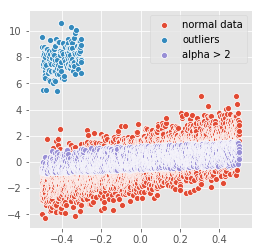

In [423]:
plt.figure(0, figsize=(4,4))
sns.scatterplot(x.data.numpy(), y.data.numpy(), label='normal data')
sns.scatterplot(x.data.numpy()[noise_dense], y.data.numpy()[noise_dense], label='outliers')
alpha_hat_dense = torch.exp(alpha_dense).data.numpy()
scale_hat_dense = torch.exp(scale_dense).data.numpy()
sns.scatterplot(x.data.numpy()[alpha_hat_dense>2], y.data.numpy()[alpha_hat_dense>2], label='alpha > 2')

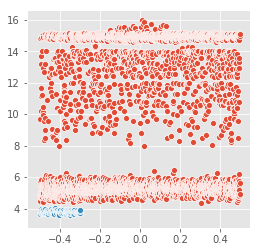

In [424]:
plt.figure(0, figsize=(4,4))
sns.scatterplot(x.data.numpy(), np.exp(alpha_hat_dense))
sns.scatterplot(x.data.numpy()[noise_dense], np.exp(alpha_hat_dense)[noise_dense])
# sns.scatterplot(x.data.numpy()[alpha_hat_dense>2], np.exp(alpha_hat_dense)[alpha_hat_dense>2])

In [425]:
X_hat_dense = x.data.numpy()[alpha_hat_dense<2]
noise_dense_hat = noise_dense[alpha_hat_dense<2]
scale_hat_dense = scale_hat_dense[alpha_hat_dense<2]
alpha_hat_dense = alpha_hat_dense[alpha_hat_dense<2]

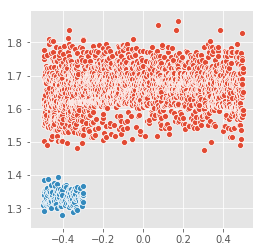

In [426]:
plt.figure(0, figsize=(4,4))
sns.scatterplot(X_hat_dense, alpha_hat_dense)
sns.scatterplot(X_hat_dense[noise_dense_hat], alpha_hat_dense[noise_dense_hat])

0   : loss=0.343025
1000: loss=0.002956
2000: loss=0.000877
3000: loss=0.000394
4000: loss=0.000205
5000: loss=0.000115
6000: loss=0.000067
7000: loss=0.000040
8000: loss=0.000024
9000: loss=0.000015


OrderedDict([('weight', Parameter containing:
              tensor([[2.7027]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([-0.4096], requires_grad=True))])

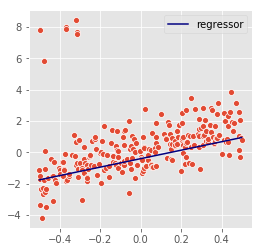

In [427]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
alpha_sparse = nn.Parameter(torch.Tensor([1]*len(x_sparse)))
scale_sparse = nn.Parameter(torch.Tensor([1]*len(x_sparse)))
optimizer = torch.optim.Adam([scale_sparse, alpha_sparse]+list(params), lr = 0.01) 
x = torch.Tensor(x_sparse)
y = torch.Tensor(y_sparse)
for epoch in range(10000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.exp(alpha_sparse), scale=torch.exp(scale_sparse)))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  
plot_regression(regression)
regression.linear._parameters

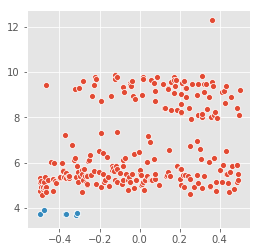

In [428]:
plt.figure(0, figsize=(4,4))
alpha_hat_sparse = torch.exp(alpha_sparse).data.numpy()
scale_hat_sparse = torch.exp(scale_sparse).data.numpy()
sns.scatterplot(x.data.numpy(), np.exp(alpha_hat_sparse))
sns.scatterplot(x.data.numpy()[noise_sparse], np.exp(alpha_hat_sparse)[noise_sparse])
# sns.scatterplot(x.data.numpy()[alpha_hat_dense>2], np.exp(alpha_hat_dense)[alpha_hat_dense>2])

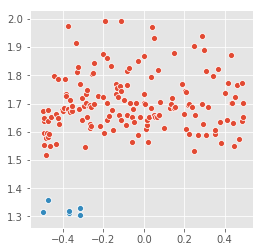

In [429]:
X_hat_sparse = x.data.numpy()[alpha_hat_sparse<2]
noise_sparse_hat = noise_sparse[alpha_hat_sparse<2]
scale_hat_sparse = scale_hat_sparse[alpha_hat_sparse<2]
alpha_hat_sparse = alpha_hat_sparse[alpha_hat_sparse<2]

plt.figure(0, figsize=(4,4))
sns.scatterplot(X_hat_sparse, alpha_hat_sparse)
sns.scatterplot(X_hat_sparse[noise_sparse_hat], alpha_hat_sparse[noise_sparse_hat])

0   : loss=0.224161
1000: loss=0.001993
2000: loss=0.000600
3000: loss=0.000269
4000: loss=0.000140
5000: loss=0.000078
6000: loss=0.000046
7000: loss=0.000027
8000: loss=0.000016
9000: loss=0.000010


OrderedDict([('weight', Parameter containing:
              tensor([[2.6912]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([-0.4629], requires_grad=True))])

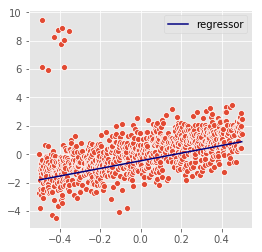

In [430]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
alpha_indep = nn.Parameter(torch.Tensor([1]*len(x_indep)))
scale_indep = nn.Parameter(torch.Tensor([1]*len(x_indep)))
optimizer = torch.optim.Adam([scale_indep, alpha_indep]+list(params), lr = 0.01) 
x = torch.Tensor(x_indep)
y = torch.Tensor(y_indep)
for epoch in range(10000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.exp(alpha_indep), scale=torch.exp(scale_indep)))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  
plot_regression(regression)
regression.linear._parameters

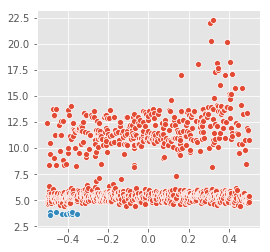

In [431]:
plt.figure(0, figsize=(4,4))
alpha_hat_indep = torch.exp(alpha_indep).data.numpy()
scale_hat_indep = torch.exp(scale_indep).data.numpy()
sns.scatterplot(x.data.numpy(), np.exp(alpha_hat_indep))
sns.scatterplot(x.data.numpy()[noise_indep], np.exp(alpha_hat_indep)[noise_indep])
# sns.scatterplot(x.data.numpy()[alpha_hat_dense>2], np.exp(alpha_hat_dense)[alpha_hat_dense>2])

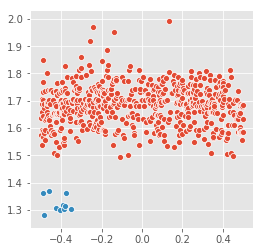

In [432]:
X_hat_indep = x.data.numpy()[alpha_hat_indep<2]
noise_indep_hat = noise_indep[alpha_hat_indep<2]
scale_hat_indep = scale_hat_indep[alpha_hat_indep<2]
alpha_hat_indep = alpha_hat_indep[alpha_hat_indep<2]

plt.figure(0, figsize=(4,4))
sns.scatterplot(X_hat_indep, alpha_hat_indep)
sns.scatterplot(X_hat_indep[noise_indep_hat], alpha_hat_indep[noise_indep_hat])

0   : loss=0.610640
1000: loss=0.005374
2000: loss=0.001572
3000: loss=0.000695
4000: loss=0.000360
5000: loss=0.000201
6000: loss=0.000116
7000: loss=0.000069
8000: loss=0.000041
9000: loss=0.000024


OrderedDict([('weight', Parameter containing:
              tensor([[3.4592]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([1.8064], requires_grad=True))])

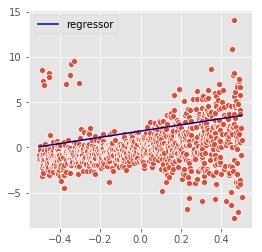

In [439]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
alpha_hetero = nn.Parameter(torch.Tensor([1]*len(x_hetero)))
scale_hetero = nn.Parameter(torch.Tensor([1]*len(x_hetero)))
optimizer = torch.optim.Adam([scale_hetero, alpha_hetero]+list(params), lr = 0.01) 
x = torch.Tensor(x_hetero)
y = torch.Tensor(y_hetero)
for epoch in range(10000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.exp(alpha_hetero), scale=torch.exp(scale_hetero)))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  
plot_regression(regression)
regression.linear._parameters

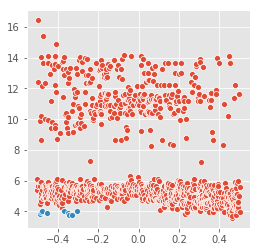

In [440]:
plt.figure(0, figsize=(4,4))
alpha_hat_hetero = torch.exp(alpha_hetero).data.numpy()
scale_hat_hetero = torch.exp(scale_hetero).data.numpy()
sns.scatterplot(x.data.numpy(), np.exp(alpha_hat_hetero))
sns.scatterplot(x.data.numpy()[noise_hetero], np.exp(alpha_hat_hetero)[noise_hetero])
# sns.scatterplot(x.data.numpy()[alpha_hat_dense>2], np.exp(alpha_hat_dense)[alpha_hat_dense>2])

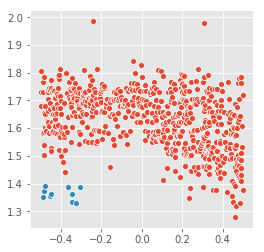

In [441]:
X_hat_hetero = x.data.numpy()[alpha_hat_hetero<2]
noise_hetero_hat = noise_hetero[alpha_hat_hetero<2]
scale_hat_hetero = scale_hat_hetero[alpha_hat_hetero<2]
alpha_hat_hetero = alpha_hat_hetero[alpha_hat_hetero<2]

plt.figure(0, figsize=(4,4))
sns.scatterplot(X_hat_hetero, alpha_hat_hetero)
sns.scatterplot(X_hat_hetero[noise_hetero_hat], alpha_hat_hetero[noise_hetero_hat])

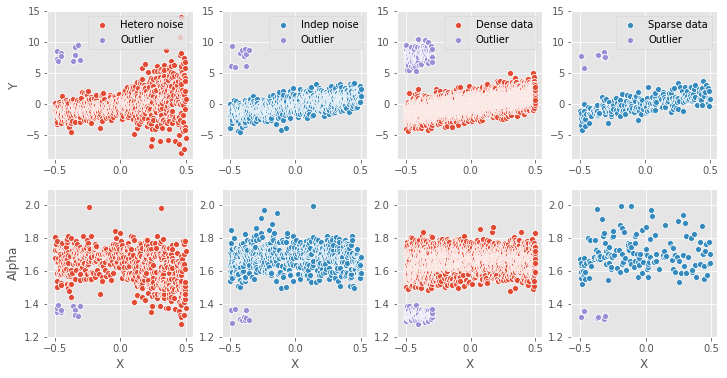

In [442]:
fig, ax = plt.subplots(2, 4, figsize=(12,6))
ax[0][0].set_ylabel('Y')
ax[0][0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_hetero, y_hetero, label='Hetero noise', color=palette[0], ax=ax[0][0])
sns.scatterplot(x_hetero[noise_hetero], y_hetero[noise_hetero], label='Outlier', color=palette[2], ax=ax[0][0])

ax[0][1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_indep, y_indep, label='Indep noise', color=palette[1], ax=ax[0][1])
sns.scatterplot(x_indep[noise_indep], y_indep[noise_indep], label='Outlier', color=palette[2], ax=ax[0][1])

ax[0][2].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_dense, y_dense, label='Dense data', color=palette[0], ax=ax[0][2])
sns.scatterplot(x_dense[noise_dense], y_dense[noise_dense], label='Outlier', color=palette[2], ax=ax[0][2])

ax[0][3].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_sparse, y_sparse, label='Sparse data', color=palette[1], ax=ax[0][3])
sns.scatterplot(x_sparse[noise_sparse], y_sparse[noise_sparse], label='Outlier', color=palette[2], ax=ax[0][3])

ax[1][0].set_ylabel('Alpha')
ax[1][0].set_xlabel('X')
ax[1][0].set_ylim([1.2, 2.1])
sns.scatterplot(X_hat_hetero, alpha_hat_hetero, color=palette[0], ax=ax[1][0])
sns.scatterplot(X_hat_hetero[noise_hetero_hat], alpha_hat_hetero[noise_hetero_hat], color=palette[2], ax=ax[1][0])

ax[1][1].set_ylim([1.2, 2.1])
ax[1][1].set_xlabel('X')
sns.scatterplot(X_hat_indep, alpha_hat_indep, color=palette[1], ax=ax[1][1])
sns.scatterplot(X_hat_indep[noise_indep_hat], alpha_hat_indep[noise_indep_hat], color=palette[2], ax=ax[1][1])

ax[1][2].set_ylim([1.2, 2.1])
ax[1][2].set_xlabel('X')
sns.scatterplot(X_hat_dense, alpha_hat_dense, color=palette[0], ax=ax[1][2])
sns.scatterplot(X_hat_dense[noise_dense_hat], alpha_hat_dense[noise_dense_hat], color=palette[2], ax=ax[1][2])

ax[1][3].set_ylim([1.2, 2.1])
ax[1][3].set_xlabel('X')
sns.scatterplot(X_hat_sparse, alpha_hat_sparse, color=palette[1], ax=ax[1][3])
sns.scatterplot(X_hat_sparse[noise_sparse_hat], alpha_hat_sparse[noise_sparse_hat], color=palette[2], ax=ax[1][3])

plt.savefig('non_param_alpha.png')

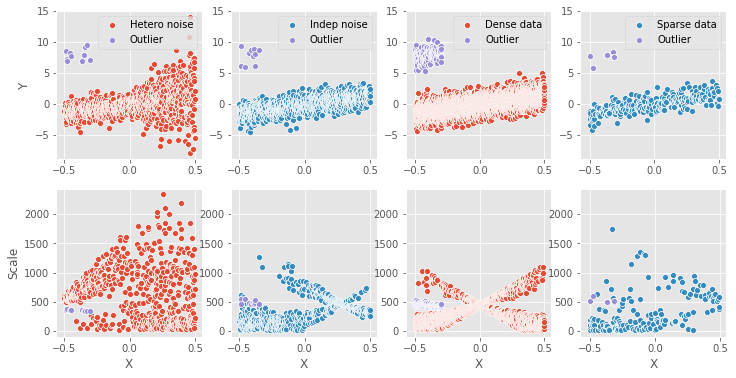

In [454]:
fig, ax = plt.subplots(2, 4, figsize=(12,6))
ax[0][0].set_ylabel('Y')
ax[0][0].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_hetero, y_hetero, label='Hetero noise', color=palette[0], ax=ax[0][0])
sns.scatterplot(x_hetero[noise_hetero], y_hetero[noise_hetero], label='Outlier', color=palette[2], ax=ax[0][0])

ax[0][1].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_indep, y_indep, label='Indep noise', color=palette[1], ax=ax[0][1])
sns.scatterplot(x_indep[noise_indep], y_indep[noise_indep], label='Outlier', color=palette[2], ax=ax[0][1])

ax[0][2].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_dense, y_dense, label='Dense data', color=palette[0], ax=ax[0][2])
sns.scatterplot(x_dense[noise_dense], y_dense[noise_dense], label='Outlier', color=palette[2], ax=ax[0][2])

ax[0][3].set_ylim([min(y_hetero)-1, max(y_hetero)+1])
sns.scatterplot(x_sparse, y_sparse, label='Sparse data', color=palette[1], ax=ax[0][3])
sns.scatterplot(x_sparse[noise_sparse], y_sparse[noise_sparse], label='Outlier', color=palette[2], ax=ax[0][3])

ax[1][0].set_ylabel('Scale')
ax[1][0].set_xlabel('X')
ax[1][0].set_ylim([-100, max(scale_hat_hetero)+100])
sns.scatterplot(X_hat_hetero, scale_hat_hetero, color=palette[0], ax=ax[1][0])
sns.scatterplot(X_hat_hetero[noise_hetero_hat], scale_hat_hetero[noise_hetero_hat], color=palette[2], ax=ax[1][0])

# ax[1][1].set_ylim([1.2, 2.1])
ax[1][1].set_xlabel('X')
ax[1][1].set_ylim([-100, max(scale_hat_hetero)+100])
sns.scatterplot(X_hat_indep, scale_hat_indep, color=palette[1], ax=ax[1][1])
sns.scatterplot(X_hat_indep[noise_indep_hat], scale_hat_indep[noise_indep_hat], color=palette[2], ax=ax[1][1])

# ax[1][2].set_ylim([1.2, 2.1])
ax[1][2].set_xlabel('X')
ax[1][2].set_ylim([-100, max(scale_hat_hetero)+100])
sns.scatterplot(X_hat_dense, scale_hat_dense, color=palette[0], ax=ax[1][2])
sns.scatterplot(X_hat_dense[noise_dense_hat], scale_hat_dense[noise_dense_hat], color=palette[2], ax=ax[1][2])

# ax[1][3].set_ylim([1.2, 2.1])
ax[1][3].set_xlabel('X')
ax[1][3].set_ylim([-100, max(scale_hat_hetero)+100])
sns.scatterplot(X_hat_sparse, scale_hat_sparse, color=palette[1], ax=ax[1][3])
sns.scatterplot(X_hat_sparse[noise_sparse_hat], scale_hat_sparse[noise_sparse_hat], color=palette[2], ax=ax[1][3])

plt.savefig('non_param_scale.png')